In [1]:
from ene300.plot import animate_pso, plot_surface, plot_objective_function
from ene300.optimization import PSO, FPA, SOS, GWO, GA
from ene300.functions import shubert, griewank, sixhump, easom, eggholder
import pickle
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from matplotlib import ticker

plt.style.use("~/Dropbox/local/mplstyle/mystyle.mplstyle")

In [2]:
from ene300.plot import plot_surface

# Conjunto de Funções Objetivo

In [3]:
def thermoelectric_system(x):
    a = np.array([26.97, 1.865, 39.79])
    b = np.array([-0.3975, -0.03988, -0.3116])
    c = np.array([0.002176, 0.001138, 0.001457])
    
    PG = x
    F = 0
    for i in range(3):
        F += a[i] + b[i]*PG[i]+c[i]*PG[i]**2
    return F

def regularized_ts(x, alpha=10):
    return thermoelectric_system(x) + alpha*(np.sum(x, axis=0)-550)**2

In [4]:
functions_params = {
    'shubert' : dict( 
        objective_function = shubert,
        position_boundary = [
            [-8, 8],  
            [-8, 8]
        ] 
    ),

    'griewank' : dict( 
        objective_function = griewank,
        position_boundary = [
            [-100, 100],   
            [-100, 100]  
        ] 
    ),

    'sixhump' : dict(
        objective_function = sixhump,
        position_boundary = [
            [-3, 3],     
            [-2, 2]    
        ] 
    ),

    'easom' : dict( 
        objective_function = easom,
        position_boundary = [
            [-5, 5], 
            [-5, 5]
        ] 
    ),

    'eggholder' : dict( 
        objective_function = eggholder,
        position_boundary = [
            [-512, 512], 
            [-512, 512]
        ] 
    ),

    'regularized_ts' : dict( 
        objective_function = regularized_ts,
        position_boundary = [
            [100, 196],  
            [50, 114]  , 
            [200, 332]] 
    ),
}

functions_optimum = {
    'shubert' : dict( 
        x = -1.42512791, 
        y = -0.80032055, 
        z = shubert(
            [-1.42512791, -0.80032055]
            )
        ),

    'griewank' : dict( 
        x = 0, 
        y = 0, 
        z = griewank(
            [0, 0]
            )
        ),

    'sixhump' : dict( 
        x = 0.0898,
        y = -0.7126, 
        z = sixhump(
            [0.0898,-0.7126]
            )
        ),

    'easom' : dict( 
        x = np.pi, 
        y = np.pi, 
        z = easom(
            [np.pi, 
             np.pi]
             )
        ),

    'eggholder' : dict( 
        x = 512, 
        y = 404.2319, 
        z = eggholder(
            [512.0, 404.2319]
            )
        ),

    'regularized_ts' : dict( 
        x = 186.6699073, 
        y = 114.,
        z = regularized_ts(
            [186.6699073 , 114. , 249.30934834]
            )
        ),
}

# Plot Functions

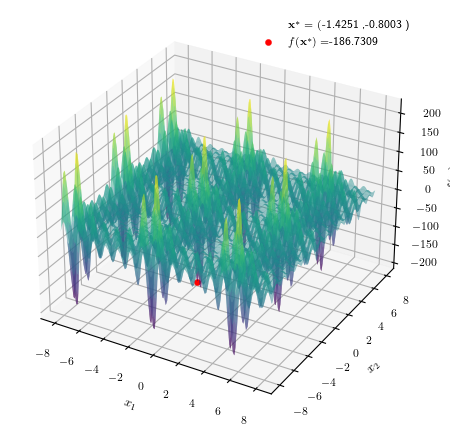

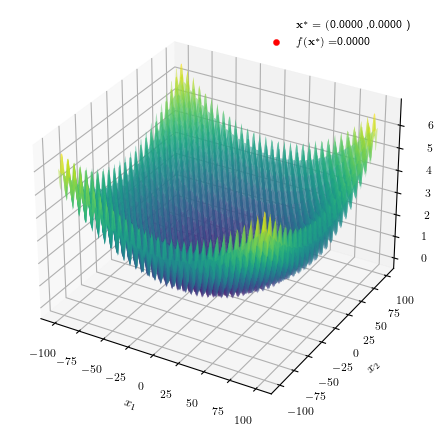

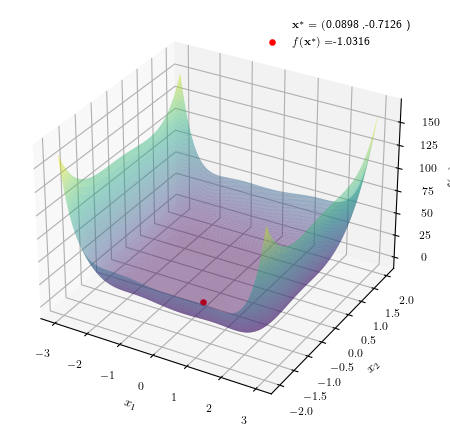

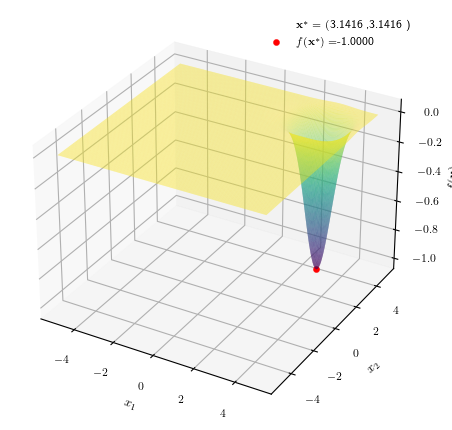

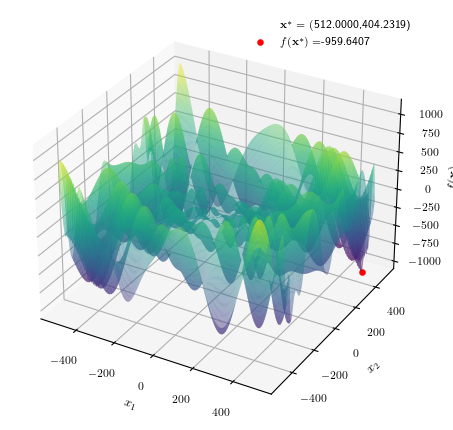

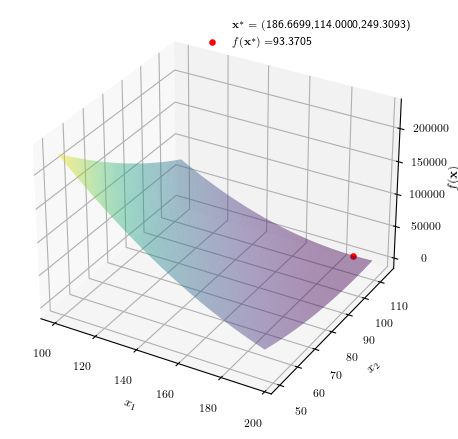

In [5]:
rt=False
for key, value in functions_params.items():
    if key == 'regularized_ts':
        rts = True
    else:
        rts = False
    plot_objective_function(
        **value, 
    #                        discretization=[100,100],
    # small resolution until i fix the bug
        discretization=[200,200],
        optimum=functions_optimum[key], 
        save_file=f"./latex/{key}_optimum.pdf", 
        rstride=1, 
        cstride=1, 
        antialiased=True, 
        regularized_ts=rts, 
        cmap='viridis', 
        alpha=0.5
    )



In [6]:
function_names = [
    'shubert', 
    'griewank', 
    'sixhump', 
    'easom', 
    'eggholder', 
    'regularized_ts'
]

function_references = [
    -186.7309, 
    0.0, 
    -1.0316, 
    -1.0, 
    -959.640, 
    250.0, 
    None
]

# Optimization Algorithms parameters

In [7]:
max_function_evaluations = 200
optimization_algorithms = {
    'PSO' : {
        'algorithm' : PSO(),                                           
        'args' : dict(   
                velocity_boundary = [-1, 1],
                #weight = dict(function='constant', constant=0.7) ,
                weight_function = dict( 
                        function='random' 
                ),
                #weight = dict(function='linear_decrease', max=2, min=0) ,
                #weight_function = dict(function='sigmoidal_increase', start=0, end=2, n=0.5, u_sign=0.15) , 
                C_function = [ 
                    dict(function='constant', constant=1),
                    dict(function='constant', constant=1.5)  
                ],
                population = 80,
                itmax = max_function_evaluations,
                max_fa = max_function_evaluations
                )
        }, 
        
    'FPA' : {
        'algorithm' : FPA(),                                           
        'args' : dict( 
                population = 80, 
                p = 0.75,
                itmax = max_function_evaluations, 
                max_fa = max_function_evaluations
                )
        }, 

    'SOS' : {
        'algorithm' : SOS(),                                           
        'args' : dict(   
                population = 80, 
                itmax = 80,
                max_fa = max_function_evaluations
                )
        },

    'GWO' : {
        'algorithm' : GWO(),                                           
        'args' : dict(   
                a_function = dict(
                        function='linear_decrease', 
                        max=2, 
                        min=0),
                population = 80, 
                itmax = max_function_evaluations,
                max_fa = max_function_evaluations
                )
        },

    'GA' : {
        'algorithm' : GA(),                                           
        'args' : dict(   
                population = 80, 
                itmax = max_function_evaluations,
                max_fa = max_function_evaluations
                )
        },
}

# RUN DOE for Statistics Study at least 20 runs for each case

In [8]:
statistics = {}
runs = 100 # will run for two runds just for testing
#functions_params = {k: functions_params[k] for k in ['eggholder']}

def generate_statistics(functions_params, optimization_algorithms):

    for function_name, function_param in functions_params.items():
        statistics[function_name] = {}

        for oa_name, oa_dict in optimization_algorithms.items():
            statistics[function_name][oa_name] = {
                'history' : [],
                'global_best' : [],
                'best_fit': [],
                'run_no': []
                }
            
            for run in range(runs):
                global_best, best_fit, history = \
                oa_dict['algorithm'](**function_param, **oa_dict['args'])
                
                statistics[function_name][oa_name]['history'].append( 
                    history 
                )
                statistics[function_name][oa_name]['global_best'].append(               
                    global_best
                )
                statistics[function_name][oa_name]['best_fit'].append( 
                    best_fit 
                )
                statistics[function_name][oa_name]['run_no'].append( 
                    run+1 
                )
                
                print(function_name, oa_name, run, best_fit)

    return statistics

In [9]:
#statistics = generate_statistics(functions_params, optimization_algorithms)

In [10]:
#with open('statistics.pkl', 'wb') as f:
#       pickle.dump(statistics, f)

In [11]:
with open('statistics.pkl', 'rb') as f:
    statistics = pickle.load(f)

# Boxplots

In [12]:
def box_plot(function_name, algorithms,  reference=None, fig=None, ax=None, error=None, ylabel=None, savefig=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    value = lambda k : statistics[function_name][k]['best_fit']
    if error is not None and reference is not None:
        value = lambda k : error(statistics[function_name][k]['best_fit'], reference)
   
    if algorithms is None:
        algorithms = list(statistics[function_name].keys())

    data = [value(k) for k in algorithms]
    
    bp_results = ax.boxplot(data)
    ax.set_xticks(list(range(1, len(data)+1)), algorithms[0:len(data)])
    #ax.set_title(function_name)

    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if reference is not None and error is None: 
        ax.axhline(reference, ls=':') 

    plt.tight_layout()
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)

    return bp_results

In [13]:
def rse(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt((x-y)**2)

def nrse(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt((x-y)**2)/abs(y)

def nrsep(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.sqrt((x-y)**2)/abs(y)*100

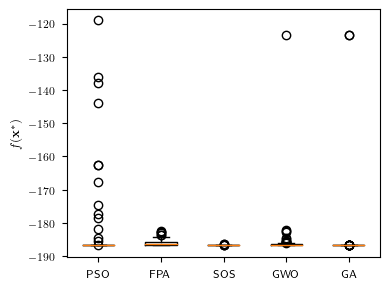

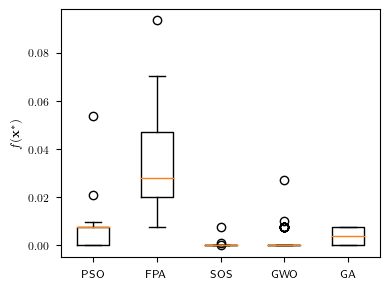

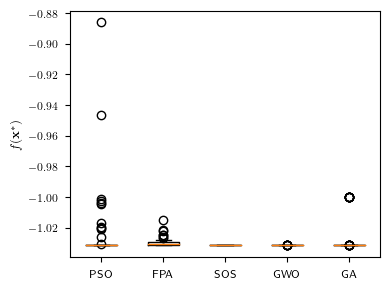

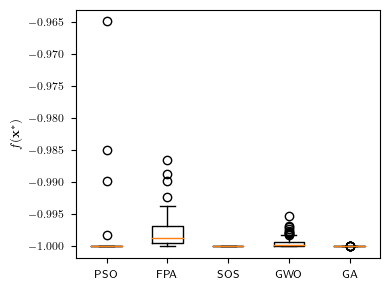

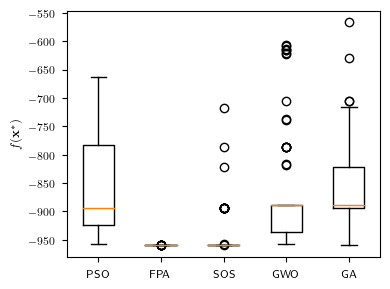

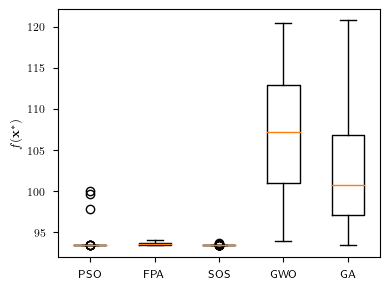

In [23]:
function_names = list(functions_params.keys())
function_references = [-186.7309, 0.0, -1.0316, -1.0, -959.640, None]
algorithms=['PSO', 'FPA', 'SOS', 'GWO', 'GA']
#fig, axs = plt.subplots(len(function_names),1)
for i, function_name in enumerate(function_names):
#    ax = axs[i]
    fig, ax = plt.subplots(figsize=(4,3))
    reference_val = function_references[i]
    box_plot(function_name, algorithms, reference=None, fig=fig, ax=ax, ylabel=rf'$f(\mathbf{{x}}^*)$', error=None, savefig=f"./latex/{function_name}_boxplot.pdf")

In [12]:
function_names = list(functions_params.keys())
function_references = [-186.7309, 0.0, -1.0316, -1.0, -959.640, None]
algorithms=['PSO', 'FPA', 'SOS', 'GWO', 'GA']
#fig, axs = plt.subplots(len(function_names),1)

dict_ = {}
dict_['function'] = []
for algorithm in algorithms:
    dict_[f'ave_{algorithm}'] = []
    dict_[f'std_{algorithm}'] = []

dict_[f'ref'] = [-186.7309, 0.0, -1.0316, -1.0, -959.640, 93.370549]
for i, function_name in enumerate(function_names):
    value = lambda k : statistics[function_name][k]['best_fit']
    dict_['function'].append( function_name )
    for algorithm in algorithms:
        data = [value(k) for k in [algorithm]]
        reference_val = function_references[i]

        dict_[f'ave_{algorithm}'].append(np.average(data))
        dict_[f'std_{algorithm}'].append(np.std(data))
        
        print('algorithm', algorithm, 'function ', function_name, ' average:',np.average(data), 'std', np.std(data))
        #bp_r = box_plot(function_name, algorithms, reference=None, fig=fig, ax=ax, ylabel=rf'$f(\mathbf{{x}}^*)$', error=None, savefig=f"./latex/{function_name}_boxplot_gwo.pgf")
        #bp_results[function_name] = bp_r

algorithm PSO function  shubert  average: -183.58125506439316 std 11.052354388670173
algorithm FPA function  shubert  average: -185.87964562781445 std 0.939753531639789
algorithm SOS function  shubert  average: -186.72112713475627 std 0.05850672492526798
algorithm GWO function  shubert  average: -185.75439750103985 std 6.322574944498477
algorithm GA function  shubert  average: -185.4663654106499 std 8.841373310264034
algorithm PSO function  griewank  average: 0.004491818224927481 std 0.006418398413899555
algorithm FPA function  griewank  average: 0.03313274373638899 std 0.018308157369318675
algorithm SOS function  griewank  average: 8.189266351764646e-05 std 0.0007393238756128718
algorithm GWO function  griewank  average: 0.001333675721148525 std 0.003702647810214461
algorithm GA function  griewank  average: 0.0036984661895217708 std 0.0036984662477265048
algorithm PSO function  sixhump  average: -1.0276323621734629 std 0.017503139839069305
algorithm FPA function  sixhump  average: -1.

In [13]:
columns=['ave_PSO', 'std_PSO', 'ave_FPA', 'std_FPA', 'ave_SOS', 'std_SOS', 'ave_GWO', 'std_GWO', 'ave_GA', 'std_GA', 'ref']

In [14]:
table = pd.DataFrame(data=dict_, index=dict_['function'], columns=['ave_PSO', 'std_PSO', 'ave_FPA', 'std_FPA', 'ave_SOS', 'std_SOS', 'ave_GWO', 'std_GWO', 'ave_GA', 'std_GA', 'ref'])
table.T

,shubert,griewank,sixhump,easom,eggholder,regularized_ts
ave_PSO,-183.581255,0.004492,-1.027632,-0.999379,-852.969122,93.543075
std_PSO,11.052354,0.006418,0.017503,0.003910,84.712095,0.993989
ave_FPA,-185.879646,0.033133,-1.030004,-0.997915,-959.618892,93.564269
std_FPA,0.939754,0.018308,0.002296,0.002418,0.035014,0.148975
ave_SOS,-186.721127,0.000082,-1.031628,-1.000000,-946.926310,93.378209
std_SOS,0.058507,0.000739,0.000000,0.000000,37.128169,0.038321
ave_GWO,-185.754398,0.001334,-1.031626,-0.999456,-878.371562,107.108031
std_GWO,6.322575,0.003703,0.000003,0.000845,87.073179,7.018048
ave_GA,-185.466365,0.003698,-1.029098,-0.999997,-856.847897,102.365485
std_GA,8.841373,0.003698,0.008581,0.000003,86.075587,6.930400


In [15]:
statistics['regularized_ts']['PSO']['global_best']

[array([186.6699091 , 114.        , 249.30934654]),
 array([186.66990914, 114.        , 249.30934652]),
 array([186.66990797, 114.        , 249.30934765]),
 array([186.66990757, 114.        , 249.30934807]),
 array([186.66990574, 114.        , 249.30934991]),
 array([186.66990821, 114.        , 249.30934741]),
 array([186.66990897, 114.        , 249.30934667]),
 array([186.66990711, 114.        , 249.30934852]),
 array([186.66990902, 114.        , 249.30934664]),
 array([186.66990674, 114.        , 249.30934886]),
 array([186.66990832, 114.        , 249.3093473 ]),
 array([186.66990846, 114.        , 249.30934715]),
 array([186.6699088 , 114.        , 249.30934683]),
 array([186.66990897, 114.        , 249.30934665]),
 array([186.66990705, 114.        , 249.30934861]),
 array([186.67094134, 114.        , 249.3082852 ]),
 array([186.66990955, 114.        , 249.30934612]),
 array([186.66990608, 114.        , 249.30934956]),
 array([186.66990898, 114.        , 249.30934666]),
 array([186.

In [18]:
pd.options.display.float_format = "{:,.4f}".format
print(table.T.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &   shubert &  griewank &  sixhump &   easom &  eggholder &  regularized\_ts \\
\midrule
ave\_PSO & -183.5813 &    0.0045 &  -1.0276 & -0.9994 &  -852.9691 &         93.5431 \\
std\_PSO &   11.0524 &    0.0064 &   0.0175 &  0.0039 &    84.7121 &          0.9940 \\
ave\_FPA & -185.8796 &    0.0331 &  -1.0300 & -0.9979 &  -959.6189 &         93.5643 \\
std\_FPA &    0.9398 &    0.0183 &   0.0023 &  0.0024 &     0.0350 &          0.1490 \\
ave\_SOS & -186.7211 &    0.0001 &  -1.0316 & -1.0000 &  -946.9263 &         93.3782 \\
std\_SOS &    0.0585 &    0.0007 &   0.0000 &  0.0000 &    37.1282 &          0.0383 \\
ave\_GWO & -185.7544 &    0.0013 &  -1.0316 & -0.9995 &  -878.3716 &        107.1080 \\
std\_GWO &    6.3226 &    0.0037 &   0.0000 &  0.0008 &    87.0732 &          7.0180 \\
ave\_GA  & -185.4664 &    0.0037 &  -1.0291 & -1.0000 &  -856.8479 &        102.3655 \\
std\_GA  &    8.8414 &    0.0037 &   0.0086 &  0.0000 &    86.0756 &          6.93

/tmp/ipykernel_7604/308567168.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.T.to_latex())


In [17]:
print(table.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
{} &   ave\_PSO &  std\_PSO &   ave\_FPA &  std\_FPA &   ave\_SOS &  std\_SOS &   ave\_GWO &  std\_GWO &    ave\_GA &  std\_GA &       ref \\
\midrule
shubert        & -183.5813 &  11.0524 & -185.8796 &   0.9398 & -186.7211 &   0.0585 & -185.7544 &   6.3226 & -185.4664 &  8.8414 & -186.7309 \\
griewank       &    0.0045 &   0.0064 &    0.0331 &   0.0183 &    0.0001 &   0.0007 &    0.0013 &   0.0037 &    0.0037 &  0.0037 &    0.0000 \\
sixhump        &   -1.0276 &   0.0175 &   -1.0300 &   0.0023 &   -1.0316 &   0.0000 &   -1.0316 &   0.0000 &   -1.0291 &  0.0086 &   -1.0316 \\
easom          &   -0.9994 &   0.0039 &   -0.9979 &   0.0024 &   -1.0000 &   0.0000 &   -0.9995 &   0.0008 &   -1.0000 &  0.0000 &   -1.0000 \\
eggholder      & -852.9691 &  84.7121 & -959.6189 &   0.0350 & -946.9263 &  37.1282 & -878.3716 &  87.0732 & -856.8479 & 86.0756 & -959.6400 \\
regularized\_ts &   93.5431 &   0.9940 &   93.5643 &   0.1490 &   93.3782 &   0.0383 &  10

/tmp/ipykernel_7604/3293683267.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


# Plot convergence with confidence level

In [21]:
def get_convergence(staticstics,function_name):

    algorithms = list(statistics[function_name].keys())
    line_data = []

    for k in range(len(statistics[function_name][algorithms[0]]['history'])):
        for a in algorithms:
            for i in statistics[function_name][a]['history'][k]['iteration']:
        
                it = statistics[function_name][a]['history'][k]['iteration'][i-1]
                best_fit = statistics[function_name][a]['history'][k]['best_fit'][i-1]
                algo = a
                line_data.append([it, best_fit, algo])

    line_data = np.array(line_data)
    line_data_df = pd.DataFrame(line_data, columns=['iteration', 'best_fit', 'algorithm'])
    
    convert_dict = {'iteration': int,
                    'best_fit': np.float64,
                    'algorithm': str }
    
    line_data_df = line_data_df.astype(convert_dict)

    return line_data_df

def plot_convergence(
    statistics, 
    function_name, 
    algorithms, 
    ylabel, 
    fig, 
    ax, 
    savefig=None):

    if fig is None and ax is None:
        fig, ax = plt.subplots()    

    line_data_df = get_convergence(statistics, function_name)
    
    if algorithms is not None:
        line_data_df = line_data_df.query(f"algorithm in {algorithms}")

    sg = sns.lineplot(line_data_df, x='iteration', y='best_fit', hue='algorithm')
    sg.set_ylabel(ylabel)
    #sg.set_title('convergence')
    sg.set_xlabel('iteration')
    #sg.set_title(function_name)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)

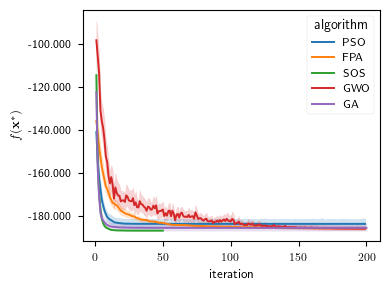

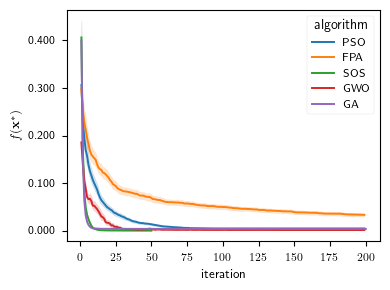

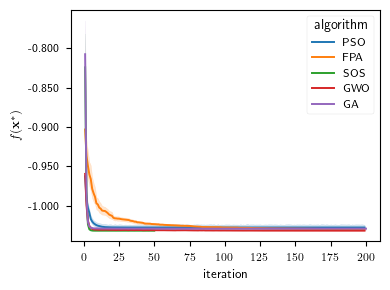

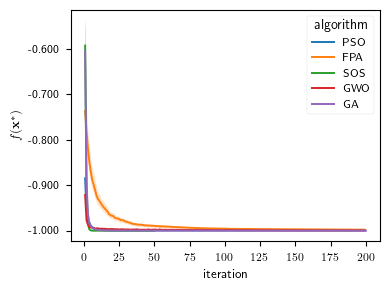

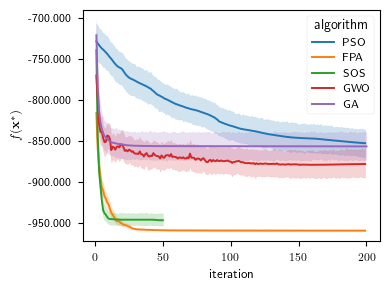

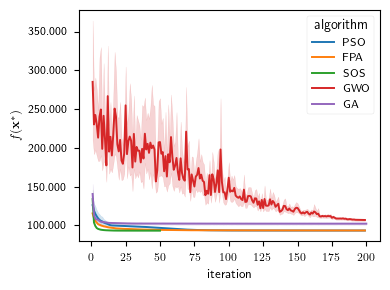

In [22]:
algorithms=list(optimization_algorithms.keys())
algorithms=['PSO', 'FPA', 'SOS', 'GWO', 'GA']

for i, function_name in enumerate(function_names):
#    ax = axs[i]
    fig, ax = plt.subplots(figsize=(4,3))
    plot_convergence(
        statistics, 
        function_name, 
        algorithms, 
        ylabel=rf'$f(\mathbf{{x}}^*)$', 
        fig=fig, 
        ax=ax , 
        savefig=f'./latex/{function_name}_convergence.pdf'
    )